<a href="https://colab.research.google.com/github/antaripg/deep-learning-notebooks/blob/main/ALL_IDB_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Checking for GPU

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Thu Jul  1 06:36:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Mounting the google Drive

In [ ]:
from google.colab import drive

drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


### Installing the necessary packages

In [ ]:
%matplotlib inline
import os
import copy
import torch
import random
import numpy as np
import torch.nn as nn
from PIL import Image
import torch.optim as optim
import matplotlib.pyplot as plt

print(torch.__version__)

1.9.0+cu102


### Load ALL_IDB data

In [ ]:
dataPath = "/content/drive/MyDrive/ALL_IDB2/ALL_IDB2/img"
listDir = os.listdir(dataPath)
random.shuffle(listDir)

In [ ]:
len(listDir)

260

In [ ]:
trainImages = torch.DoubleTensor(200, 3072)
trainLabels = torch.DoubleTensor(200)
testImages = torch.DoubleTensor(60, 3072)
testLabels = torch.DoubleTensor(60)

img_no = 0
for fname in listDir:
  im = Image.open(dataPath+'/'+fname)
  im = im.resize((32,32))
  im = np.array(im)
  im = np.reshape(im, 32*32*3 )
  if img_no < 200:
    trainImages[img_no] = torch.from_numpy(im)
    trainLabels[img_no] = int(listDir[img_no][6:7]) # the label is at the 6th position of the file name
  else:
    testImages[img_no - 200] = torch.from_numpy(im)
    testLabels[img_no - 200] = int(listDir[img_no][6:7])
  img_no = img_no + 1

## Viewing one RANDOM Image from the training set

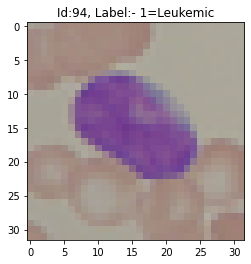

In [ ]:
# id = int(np.random.randint(0, 200, 1))
# arr = trainImages[id].numpy()
# label = int(trainLabels[id].numpy())
# label_dict ={1:'Leukemic', 0:'Non-leukemic'}
# arr = arr.reshape((32,32,3))
# arr = arr/255
# plt.figure()
# plt.title(('Id:{}, Label:- {}={}'.format(id,label,label_dict[label])))
# plt.imshow(arr)
# plt.show()

In [ ]:
print(trainImages.size())
print(trainLabels.size())
print(testImages.size())
print(testLabels.size())

torch.Size([200, 3072])
torch.Size([200])
torch.Size([60, 3072])
torch.Size([60])


### Availability of GPU

In [ ]:
# Checking availability of GPU

use_gpu = torch.cuda.is_available()
if use_gpu:
  print("GPU is available!")
  device = 'cuda'
else:
  print("GPU not available!")
  device = 'cpu'

GPU is available!


### Define the autoencoder

In [ ]:
class autoencoder(nn.Module):
  def __init__(self):
    super(autoencoder, self).__init__()
    self.encoder = nn.Sequential(
      nn.Linear(32*32*3, 100),
      nn.ReLU(),
      nn.Linear(100, 100),
      nn.ReLU())
    self.decoder = nn.Sequential(
      nn.Linear(100, 100),
      nn.ReLU(),
      nn.Linear(100, 32*32*3),
      nn.ReLU())

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x


net = autoencoder()
print(net)

net = net.double().to(device)

for layer in net.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()
init_weights = copy.deepcopy(net.encoder[0].weight.data)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=3072, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=3072, bias=True)
    (3): ReLU()
  )
)


### Define Optimization Technique

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

### Train the autoencoder

In [ ]:
iterations = 100
batchSize = 10
for epoch in range(iterations):
  runningLoss = 0
  for i in range(int(trainImages.size()[0]/batchSize)):
    inputs = torch.index_select(trainImages,0,torch.linspace(i*batchSize,(i+1)*batchSize - 1,steps=batchSize).long()).double()
    inputs = inputs/255
    inputs = inputs.to(device)
    # print(inputs)
    optimizer.zero_grad()
    outputs = net(inputs)
    # print(outputs)
    loss = criterion(outputs, inputs)
    loss.backward()
    optimizer.step()
    runningLoss += loss.item()
  print("At iteration :%d / %d ; Mean Squared Error: %f"%(epoch+1, iterations, runningLoss/(trainImages.size()[0]/batchSize)))

print("Finished Training")

At iteration :1 / 100 ; Mean Squared Error: 0.094239
At iteration :2 / 100 ; Mean Squared Error: 0.094237
At iteration :3 / 100 ; Mean Squared Error: 0.094235
At iteration :4 / 100 ; Mean Squared Error: 0.094234
At iteration :5 / 100 ; Mean Squared Error: 0.094233
At iteration :6 / 100 ; Mean Squared Error: 0.094232
At iteration :7 / 100 ; Mean Squared Error: 0.094231
At iteration :8 / 100 ; Mean Squared Error: 0.094231
At iteration :9 / 100 ; Mean Squared Error: 0.094230
At iteration :10 / 100 ; Mean Squared Error: 0.094230
At iteration :11 / 100 ; Mean Squared Error: 0.094229
At iteration :12 / 100 ; Mean Squared Error: 0.094229
At iteration :13 / 100 ; Mean Squared Error: 0.094228
At iteration :14 / 100 ; Mean Squared Error: 0.094228
At iteration :15 / 100 ; Mean Squared Error: 0.094228
At iteration :16 / 100 ; Mean Squared Error: 0.094227
At iteration :17 / 100 ; Mean Squared Error: 0.094227
At iteration :18 / 100 ; Mean Squared Error: 0.094227
At iteration :19 / 100 ; Mean Squared

### Encoder Weights Visualization

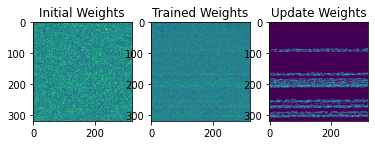

In [ ]:
trained_weights = copy.deepcopy(net.encoder[0].weight.data)
init_weights = (1 + init_weights)*127.5
trained_weights = (1 + trained_weights)*127.5

init_weights = init_weights.view(3, 320, 320).byte()
trained_weights = trained_weights.view(3, 320, 320).byte()

if device == 'cuda':
  init_weights = init_weights.cpu()
  trained_weights = trained_weights.cpu()
d_weights  = init_weights - trained_weights

fig = plt.figure()
plot = fig.add_subplot(1, 3, 1)
img = np.array(init_weights.numpy())[0]
plot.set_title("Initial Weights")
imgplot = plt.imshow(img)

plot = fig.add_subplot(1, 3, 2)
img = np.array(trained_weights.numpy())[0]
plot.set_title("Trained Weights")
imgplot = plt.imshow(img)

plot = fig.add_subplot(1, 3, 3)
img = np.array(d_weights.numpy())[0]
plot.set_title("Update Weights")
imgplot = plt.imshow(img)

plt.show()


### Change the decoder part to a classifier

In [ ]:
new_classifier = nn.Sequential(*list(net.children())[:-1]) # removes the decoder
# print(new_classifier)
net = new_classifier
net.add_module('classifier', nn.Sequential(nn.Linear(100,2), nn.LogSoftmax(dim=1)))

net = net.double().to(device)
cll_weights = copy.deepcopy(net[0][0].weight.data)
init_classifier_weights = copy.deepcopy(net.classifier[0].weight.data)
print(net)
print(cll_weights.shape, init_classifier_weights.shape)

Sequential(
  (0): Sequential(
    (0): Linear(in_features=3072, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=2, bias=True)
    (1): LogSoftmax(dim=1)
  )
)
torch.Size([100, 3072]) torch.Size([2, 100])


### Defining the Loss and Optimizer function

In [ ]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

In [ ]:
iterations = 100
batchSize = 10
for epoch in range(iterations):
    runningLoss = 0
    for i in range(int(trainImages.size()[0]/batchSize)):
        inputs = torch.index_select(trainImages,0,torch.linspace(i*batchSize,(i+1)*batchSize - 1,steps=batchSize)
                                  .long()).double()
        labels = torch.index_select(trainLabels,0,torch.linspace(i*batchSize,(i+1)*batchSize - 1,steps=batchSize)
                                  .long()).long()
        inputs = inputs/255
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        runningLoss += loss.item()

    inputs = testImages.double()/255
    inputs = inputs.to(device)
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
    if use_gpu:
        predicted = predicted.cpu()
    correct = 0
    total = 0
    total += testLabels.size(0)
    correct += (predicted == testLabels).sum()
    print('At Iteration: %d / %d  ;  Training Loss: %f ; Testing Acc: %f '%(epoch + 1,iterations,runningLoss/
                                                                            (trainImages.size()[0]/
                                                                             batchSize),(100 * correct/ float(total))))
print('Finished Training')



At Iteration: 1 / 100  ;  Training Loss: 0.025009 ; Testing Acc: 83.333336 
At Iteration: 2 / 100  ;  Training Loss: 0.029940 ; Testing Acc: 83.333336 
At Iteration: 3 / 100  ;  Training Loss: 0.014356 ; Testing Acc: 80.000000 
At Iteration: 4 / 100  ;  Training Loss: 0.059784 ; Testing Acc: 83.333336 
At Iteration: 5 / 100  ;  Training Loss: 0.015685 ; Testing Acc: 83.333336 
At Iteration: 6 / 100  ;  Training Loss: 0.026147 ; Testing Acc: 83.333336 
At Iteration: 7 / 100  ;  Training Loss: 0.012106 ; Testing Acc: 78.333336 
At Iteration: 8 / 100  ;  Training Loss: 0.025928 ; Testing Acc: 85.000000 
At Iteration: 9 / 100  ;  Training Loss: 0.016646 ; Testing Acc: 83.333336 
At Iteration: 10 / 100  ;  Training Loss: 0.011894 ; Testing Acc: 83.333336 
At Iteration: 11 / 100  ;  Training Loss: 0.025271 ; Testing Acc: 83.333336 
At Iteration: 12 / 100  ;  Training Loss: 0.014716 ; Testing Acc: 81.666664 
At Iteration: 13 / 100  ;  Training Loss: 0.026805 ; Testing Acc: 83.333336 
At Itera

### Visualize the Encoder Weights

torch.Size([100, 3072]) torch.Size([100, 3072])


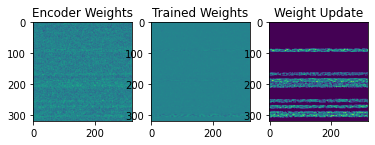

In [ ]:
cll_weights_ft = copy.deepcopy(net[0][0].weight.data)
cll_weights = (1 + cll_weights)*127.5
cll_weights_ft = (1 + cll_weights_ft)*127.5
print(cll_weights_ft.shape, cll_weights.shape)
cll_weights = cll_weights.view(3, 320, 320).byte()
cll_weights_ft = cll_weights_ft.view(3, 320, 320).byte()
if use_gpu:
  cll_weights = cll_weights.cpu()
  cll_weights_ft = cll_weights_ft.cpu()
d_weights = cll_weights_ft - cll_weights

# plotting the weights
fig = plt.figure()
plot = fig.add_subplot(1, 3, 1)
img =np.array(cll_weights.numpy())[0]
plot.set_title("Encoder Weights")
imgplot = plt.imshow(img)

plot = fig.add_subplot(1, 3, 2)
img =np.array(cll_weights_ft.numpy())[0]
plot.set_title("Trained Weights")
imgplot = plt.imshow(img)

plot = fig.add_subplot(1, 3, 3)
img =np.array(d_weights.numpy())[0]
plot.set_title("Weight Update")
imgplot = plt.imshow(img)
plt.show()



### Classifier Weights Visualization

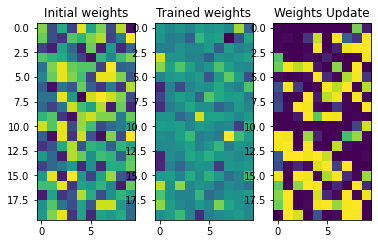

In [ ]:
trained_classifier_weights = copy.deepcopy(net.classifier[0].weight.data)
init_classifier_weights = (1+ init_classifier_weights)*127.5
trained_classifier_weights = (1 + trained_classifier_weights)*127.5

init_classifier_weights = init_classifier_weights.view(-1, 20, 10).byte()
trained_classifier_weights = trained_classifier_weights.view(-1, 20, 10).byte()

if use_gpu:
  init_classifier_weights = init_classifier_weights.cpu()
  trained_classifier_weights = trained_classifier_weights.cpu()

d_weights = init_classifier_weights - trained_classifier_weights

fig = plt.figure()
plot = fig.add_subplot(1, 3, 1)
img = np.array(init_classifier_weights.numpy())[0]
plot.set_title('Initial weights')
plt.imshow(img)

plot = fig.add_subplot(1, 3, 2)
img = np.array(trained_classifier_weights.numpy())[0]
plot.set_title('Trained weights')
plt.imshow(img)

plot = fig.add_subplot(1, 3, 3)
img = np.array(d_weights.numpy())[0]
plot.set_title('Weights Update')
plt.imshow(img)
plt.show()
